In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot
import cav as cav

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from scipy import stats

import tensorflow


Using TensorFlow backend.


In [2]:
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA

In [3]:
K.set_learning_phase(0)
model = load_model('v3_model.h5')

/Users/tyler/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

tf.logging.set_verbosity(0)

working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'

label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

In [7]:
layer = 'mixed10'
concepts = ['striped_sub_1','knitted_sub_1','dotted_sub_1','grid_sub_1',
            'green_sub_1','yellow_sub_1','blue_sub_1','orange_sub_1',
            'sky_sub_1','ocean_sub_1','grassland_sub_1','road_sub_1',]

#concepts = ['sky_sub_1','ocean_sub_1','grassland_sub_1','road_sub_1']
all_acts = None
colors = None
for idx,c in enumerate(concepts):
    my_acts,_ = get_acts_for_concept(c,layer)
    if all_acts is not None:
        all_acts = np.concatenate((all_acts,my_acts))
        colors = np.concatenate((colors,np.ones(50) * idx))
    else:
        all_acts = my_acts
        colors = np.ones(50) * idx

In [8]:
## TSNE
embed_t = TSNE(n_components=2, perplexity=5,).fit_transform(all_acts)
embed = embed_t

In [156]:
this_umap = umap.UMAP(n_components=2, n_neighbors=50, random_state=43).fit(all_acts)

embed_umap = this_umap.transform(all_acts)
embed = embed_umap

In [147]:
pca = PCA(n_components=2)

embed_p = pca.fit_transform(all_acts)
embed = embed_p

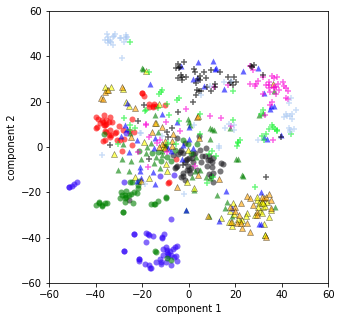

In [12]:
fig = plt.figure(figsize=[5,5])

concept_names = [a[:-6] for a in concepts]

start = 0

my_colors = ['red', '#1e1d22','#3205f9','green',
             'green','#fdff00','blue','orange',
             '#f903d5','#000000','#11f22c','#aac8f2',]

markers = ['o','o','o','o',
           '^','^','^','^',
           '+','+','+','+',
           'x','x','x','x']

linewidths = [0,0,0,0,
             0,.5,0,.5,
             0,0,0,0]

#markers = ['o','^','+']
#my_colors = ['red','blue','green']
#concept_names = ['textures','colors','scenes']

grouped = False
if grouped:
    
    for i in range(0,3):
        start = i*50*4
        stop = i*50*4+50*4
        plt.scatter(embed[start:stop,0], embed[start:stop,1], color = my_colors[i],label=concept_names[i],alpha=.6,linewidths=0,marker=markers[i])
else:
    for i in range(0,12):
        start = i*50
        stop = i*50+50
        plt.scatter(embed[start:stop,0], embed[start:stop,1], color = my_colors[i],label=concept_names[i],alpha=.6,linewidths=linewidths[i],marker=markers[i],edgecolor='k')


#plt.legend(loc='upper left')

#ax_len = 8
x_len = 60
y_len = 60
plt.xlim([-x_len,x_len])
plt.ylim([-y_len,y_len])


ax = plt.gca()
lgd = ax.legend(bbox_to_anchor=(1.03, .7),fontsize=14,markerscale=1.5)

plt.xlabel('component 1')
plt.ylabel('component 2')

#plt.savefig('new_figs/embeddings/tmp.png',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('new_figs/embeddings/tmp.png',dpi=400, bbox_inches='tight')




In [5]:
## get activations for concept, layer


def get_acts_for_concept(concept,layer):
    concept_dir = os.path.join(working_dir,'concepts/'+concept)
    image_list = files_from_dir_ext(concept_dir,'jp')
    image_list.sort()

    act_path = os.path.join(working_dir,'final_acts/' + concept + '-' + layer + '.pkl')

    n = size_dict[layer]
    nn = size_dict_orig[layer]

    try:
        this_dict = pickle.load(open(act_path, 'rb'))
    except:
        this_dict = {}
        
    #print(nn)
    
    acts_ran = np.zeros((len(image_list),n))
    orig = np.zeros((len(image_list),nn[1],nn[2],nn[3]))
    
    for idx,image_path in enumerate(image_list):
        if image_path not in this_dict:
            img = prep2(os.path.join(concept_dir,image_path))
            this_img = np.expand_dims(img, axis=0)
            acts_orig = get_acts_for_layer_new(layer,this_img)
            acts_ran[idx] = acts_orig.reshape(-1)
            orig[idx] = acts_orig
            this_dict[image_path] = (acts_orig.reshape(-1),acts_orig)
        else:
            acts_ran[idx],orig[idx] = this_dict[image_path]
            #print('acts already exist')

    pickle.dump(this_dict,open(act_path, 'wb'))
    
    return acts_ran,orig


def make_orig_cav(x_train,y_train):
    lm = linear_model.SGDClassifier(alpha=.1)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

def make_orig_cav_seed(x_train,y_train,seed):
    lm = linear_model.SGDClassifier(alpha=.1,random_state=seed)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

def make_L1_cav(x_train,y_train):
    x_train_p_list,x_train_n_list =[],[]
    for idx,a in enumerate(x_train):
        if y_train[idx] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
    L1_cav = get_L1(x_train_p) - get_L1(x_train_n)
    return L1_cav

def make_centroid_cav(x_train,y_train):
    x_train_p_list,x_train_n_list =[],[]
    for idx,a in enumerate(x_train):
        if y_train[idx] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
    centroid_cav = x_train_p.mean(axis=1) - x_train_n.mean(axis=1)
    return centroid_cav

def make_L1_cav_and_means(x_train,y_train):
    x_train_p_list,x_train_n_list =[],[]
    for idx,a in enumerate(x_train):
        if y_train[idx] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
    mu_p = get_L1(x_train_p)
    mu_n = get_L1(x_train_n)
    L1_cav = mu_p - mu_n
    return L1_cav,mu_p,mu_n

def get_L1(act_for_L1):
    return np.linalg.norm(act_for_L1.T,1,axis = 1) / act_for_L1.shape[1]

In [6]:
## define functions
pca_components = pickle.load(open('pca/pca_components_mixed9.pkl', 'rb'))

def get_dir_from_pert(pred_1):
    a = 0
    pred_2 = second_part_model.get_predictions(pred_1)
    decoded = decode_predictions(pred_2, top=1000)
    p1 = get_p(decoded,'zebra')

    a = .01
    to_concept = 'striped_sub_1'
    pred_1_pert = this_cav.perturb_act(pred_1,to_concept,alpha = a)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    decoded = decode_predictions(pred_2, top=1000)
    p2 = get_p(decoded,'zebra')

    return (p2-p1) / a

def get_p(decoded,class_name):
    for d in decoded[0]:
        if d[1] ==class_name:
            z = d[2]
    if z:
        return z


def vector_norm(vec):
    norm_const = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
    return vec / norm_const

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

## CAV distance
def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def cosine_similarity(v1,v2):
    # compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy / math.sqrt(sumxx*sumyy)

def files_from_dir(a_dir):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    return onlyfiles

def files_from_dir_ext(a_dir,ext):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    this_ext = [e for e in onlyfiles if ext in e.lower()]
    return this_ext

def prep2(filename):
    shape=(299, 299)
    img = np.array(PIL.Image.open(open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
    # Normalize pixel values to between 0 and 1.
    img = np.float32(img) / 255.0
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        return None
    else:
        return img

this_img = np.expand_dims(prep2('concepts/random500_0/ILSVRC2012_val_00001172.JPEG'),axis=0)
    
layer_dict = dict([(layer.name, layer) for layer in model.layers])
sess = K.get_session()

layer_name = 'mixed9'

these_acts = layer_dict[layer_name].output
get_acts_func = K.function([model.input],[these_acts])

#name_ph = K.placeholder(dtype='string')
#these_acts_for_layer = layer_dict[name_ph].output
#get_acts_for_layer_func = K.function([name_ph,model.input],[these_acts_for_layer])

def get_acts(input_img):
    outs = get_acts_func([input_img])
    acts_value = outs[0]
    return acts_value.reshape(-1)

def get_acts_for_layer(layer_name,input_img):
    acts_value = layer_dict[layer_name].output
    outs = get_acts_for_layer_func([layer_name,input_img])
    acts_value = outs[0]
    return acts_value.reshape(-1)


acts_mixed0_f = K.function([model.input],[layer_dict['mixed0'].output])
acts_mixed1_f = K.function([model.input],[layer_dict['mixed1'].output])
acts_mixed2_f = K.function([model.input],[layer_dict['mixed2'].output])
acts_mixed3_f = K.function([model.input],[layer_dict['mixed3'].output])
acts_mixed4_f = K.function([model.input],[layer_dict['mixed4'].output])
acts_mixed5_f = K.function([model.input],[layer_dict['mixed5'].output])
acts_mixed6_f = K.function([model.input],[layer_dict['mixed6'].output])
acts_mixed7_f = K.function([model.input],[layer_dict['mixed7'].output])
acts_mixed8_f = K.function([model.input],[layer_dict['mixed8'].output])
acts_mixed9_f = K.function([model.input],[layer_dict['mixed9'].output])
acts_mixed10_f = K.function([model.input],[layer_dict['mixed10'].output])

def get_acts_for_layer_new(layer_name,input_img):
    acts = None
    if layer_name=='mixed0':
        acts = acts_mixed0_f([input_img])[0]
    if layer_name=='mixed1':
        acts = acts_mixed1_f([input_img])[0]
    if layer_name=='mixed2':
        acts = acts_mixed2_f([input_img])[0]
    if layer_name=='mixed3':
        acts = acts_mixed3_f([input_img])[0]
    if layer_name=='mixed4':
        acts = acts_mixed4_f([input_img])[0]
    if layer_name=='mixed5':
        acts = acts_mixed5_f([input_img])[0]
    if layer_name=='mixed6':
        acts = acts_mixed6_f([input_img])[0]
    if layer_name=='mixed7':
        acts = acts_mixed7_f([input_img])[0]
    if layer_name=='mixed8':
        acts = acts_mixed8_f([input_img])[0]
    if layer_name=='mixed9':
        acts = acts_mixed9_f([input_img])[0]
    if layer_name=='mixed10':
        acts = acts_mixed10_f([input_img])[0]
    
    return acts


bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']

size_dict = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict[bn] = acts_orig.reshape(-1).shape[0]
    
size_dict_orig = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict_orig[bn] = acts_orig.shape